# Yankees - Propensity Event- Tier 2 to 4
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 31, 2022

## Hypothesis
We can help teams predict who will buy a single ticket to the next game based on the historical data we have on that fan. This also requires engineering a new feature (isNextGameBuyer) in order to make a prediction on if the fan will buy a ticket to the next game or not.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '54.164.224.129'  
DATABASE = 'stlrRays' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 53 # Yankees

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrYankees].[ds].[getPropensityEventScoring] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"]) 

CNXN.commit()
cursor.close()

df.shape

(818954, 46)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818954 entries, 0 to 818953
Data columns (total 46 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lkupClientId            818954 non-null  int64  
 1   dimCustomerMasterId     818954 non-null  int64  
 2   dimEventId              818954 non-null  int64  
 3   inMarket                818954 non-null  bool   
 4   customerNumber          818954 non-null  object 
 5   year                    818954 non-null  int64  
 6   productGrouping         818954 non-null  object 
 7   Tier                    818954 non-null  int64  
 8   eventDay                818954 non-null  int64  
 9   totalSpent              818954 non-null  float64
 10  recentDate              818954 non-null  object 
 11  attendancePercent       818954 non-null  float64
 12  renewedBeforeDays       818954 non-null  int64  
 13  isBuyer                 818954 non-null  object 
 14  source_tenure       

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = ["dimCustomerMasterId",
        "inMarket",
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "distToVenue",
        "totalGames",
        "recency",
        "click_link",
        "fill_out_form",
        "open_email" ,
        "send_email",
        "unsubscribe_email",
        "openToSendRatio",
        "clickToSendRatio",
        "clickToOpenRatio",
        "Tier",
        "eventDay",
        "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]
#df_dataset = df_dataset[df_dataset["Tier"] == {1,2,3} ]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (629260, 20)
Unseen Data For Predictions: (111046, 20)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="Tier", 
    train_size = 0.80,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","year"],
    silent=True,
    verbose=False,
    numeric_features=["inMarket",
        "attendancePercent",
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "distToVenue",
        "totalGames",
        "recency",
        "eventDay",
        "click_link",
        "fill_out_form",
        "open_email" ,
        "send_email",
        "unsubscribe_email",
        "openToSendRatio",
        "clickToSendRatio",
        "clickToOpenRatio"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["gbc", "lightgbm", "lr", "rf", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7380,0.8965,0.7330,0.7365,0.7367,0.6043,0.6048,29.0300
xgboost,Extreme Gradient Boosting,0.7303,0.8979,0.7246,0.7286,0.7286,0.5924,0.5930,49.4380
lightgbm,Light Gradient Boosting Machine,0.7189,0.8892,0.7130,0.7165,0.7166,0.5752,0.5760,3.9280
gbc,Gradient Boosting Classifier,0.6552,0.8427,0.6521,0.6525,0.6502,0.4809,0.4837,70.2920
lr,Logistic Regression,0.5545,0.7410,0.5319,0.5475,0.5227,0.3160,0.3317,33.1290


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7384,0.8961,0.7333,0.7368,0.7371,0.6049,0.6053
1,0.7368,0.8954,0.7316,0.7349,0.7353,0.6024,0.6029
2,0.7410,0.8980,0.7358,0.7396,0.7398,0.6088,0.6092
3,0.7379,0.8963,0.7329,0.7365,0.7367,0.6042,0.6046
4,0.7412,0.8973,0.7364,0.7398,0.7400,0.6092,0.6095
5,0.7382,0.8965,0.7334,0.7367,0.7369,0.6046,0.6050
6,0.7348,0.8952,0.7295,0.7332,0.7333,0.5994,0.5999
7,0.7370,0.8956,0.7321,0.7353,0.7356,0.6028,0.6032
8,0.7385,0.8974,0.7334,0.7369,0.7372,0.6050,0.6054
9,0.7365,0.8970,0.7316,0.7351,0.7353,0.6021,0.6025


### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(78648, 46)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,dimEventId,inMarket,customerNumber,year,productGrouping,Tier,eventDay,totalSpent,...,phonecall,text,unknown,credits_after_refund,NumberofGamesPerSeason,isNextGameBuyer,Label,Score_2,Score_3,Score_4
740306,53,439,913,True,1213275,2021,Online Individual Game,3,7,170.0,...,0,0,0,0.0,94,0,2,0.46,0.29,0.25
740307,53,822,905,True,10605691,2021,Online Individual Game,4,7,660.0,...,0,0,0,0.0,94,0,2,0.43,0.27,0.30
740308,53,1017,526,True,26719583,2021,Online Individual Game,4,5,0.0,...,0,0,0,0.0,94,0,3,0.16,0.78,0.06
740309,53,1943,1254,True,1394871,2021,Online Individual Game,2,5,220.0,...,0,0,0,0.0,94,0,3,0.49,0.50,0.01
740310,53,2586,102,False,13241926,2021,Online Individual Game,3,3,280.0,...,0,0,0,0.0,94,0,3,0.27,0.39,0.34


In [11]:
new_predictions["Label"].value_counts()

2    37438
3    30281
4    10929
Name: Label, dtype: int64

In [13]:
new_predictions["Score_2"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(0.2, 0.4]       29805
(0.4, 0.6]       19450
(0.6, 0.8]       16265
(-0.001, 0.2]     7918
(0.8, 1.0]        5210
Name: Score_2, dtype: int64

In [14]:
new_predictions["Score_3"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    23882
(0.2, 0.4]       21994
(0.4, 0.6]       18656
(0.6, 0.8]       12558
(0.8, 1.0]        1558
Name: Score_3, dtype: int64

In [15]:
new_predictions["Score_4"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    53567
(0.2, 0.4]       13890
(0.4, 0.6]        5253
(0.6, 0.8]        4589
(0.8, 1.0]        1349
Name: Score_4, dtype: int64

array([[<AxesSubplot:title={'center':'Score_2'}>]], dtype=object)

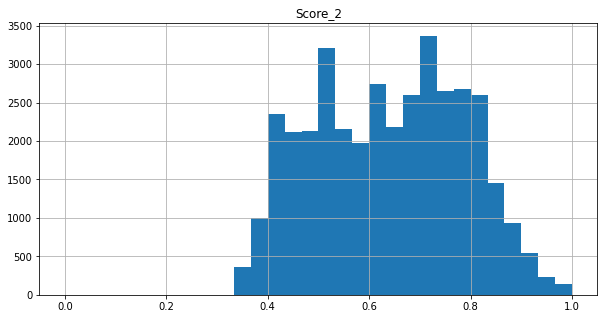

In [16]:
new_predictions[new_predictions["Label"]==2][["Score_2"]].hist(bins=30, figsize=(10,5), range=[0,1])

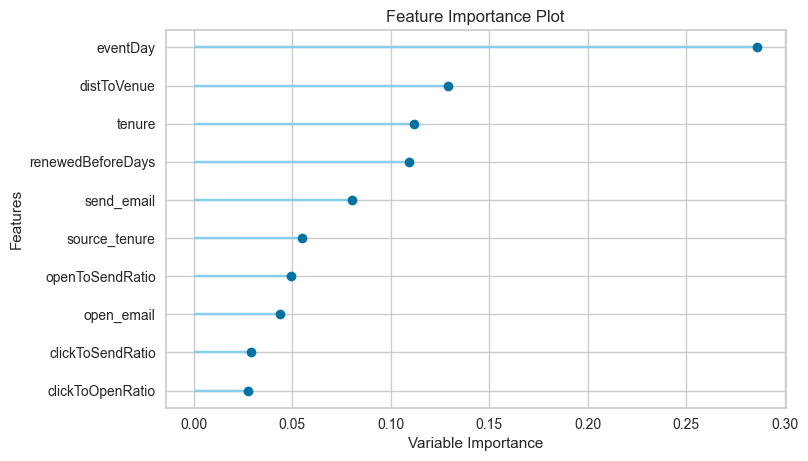

In [17]:
plot_model(best_model, plot='feature')

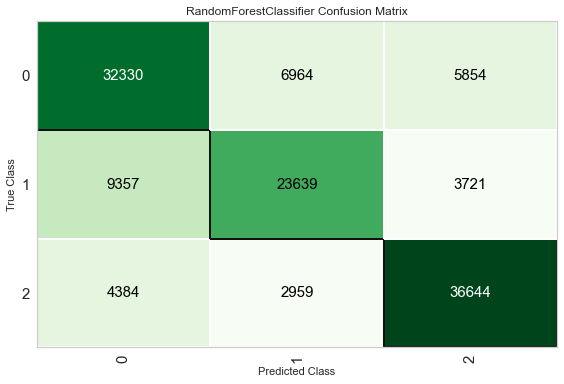

In [18]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?

* We should ask CS/CI what they think the most significant factor towards a next game buyer is.